# Problem statement: 
* The data has 777 rows and 17 variables. Dataset is imbalanced: 212 Public vs. 565 Private schools. 
* This is a binary classification problem. The classification goal is to detect school type: Public or Private.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
    
 # Model Training: 
- I separately train following models:
     - Logistic Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model. Also, I undersample the majority class to even the imbalances. 

  # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - roc_auc score
     - f1 score
     - Confusion matrix
     - ROC curve  
     - Average precision
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark

import sklearn
import numpy as np
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# helpful function to detect the Missing Values:
def detect_missing(df):
    import pyspark.sql.functions as fn
    miss_count=df.agg(*[(fn.count('*')-fn.count(c)).alias(c)   for c in df.columns]).toPandas()
    miss_percent=df.agg(*[(1-(fn.count(c)/fn.count('*'))).alias(c)   for c in df.columns]).toPandas()
    
    summary = pd.concat([miss_count, miss_percent], axis=0)
    summary['  '] = ['Count of miss values: ', 'Percentage of miss values: ']
    summary.set_index('  ', inplace=True)
    return summary

# helpful function to detect the Duplicate Values:
def detect_duplicates(df):
    print('Count of rows: ', df.count())
    print('Count of distinct rows: ', df.distinct().count())

In [3]:
from pyspark.sql import SparkSession
my_spark=SparkSession.builder.appName('college_project').getOrCreate()

In [4]:
df=my_spark.read.csv('College.csv', header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- School: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: integer (nullable = true)
 |-- Accept: integer (nullable = true)
 |-- Enroll: integer (nullable = true)
 |-- Top10perc: integer (nullable = true)
 |-- Top25perc: integer (nullable = true)
 |-- F_Undergrad: integer (nullable = true)
 |-- P_Undergrad: integer (nullable = true)
 |-- Outstate: integer (nullable = true)
 |-- Room_Board: integer (nullable = true)
 |-- Books: integer (nullable = true)
 |-- Personal: integer (nullable = true)
 |-- PhD: integer (nullable = true)
 |-- Terminal: integer (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: integer (nullable = true)
 |-- Expend: integer (nullable = true)
 |-- Grad_Rate: integer (nullable = true)



In [6]:
pd.DataFrame(df.take(3), columns=df.columns)

,School,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54


In [10]:
df.describe().toPandas()

,summary,School,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
0,count,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777,777
1,mean,None,None,3001.6383526383524,2018.8043758043757,779.972972972973,27.55855855855856,55.7966537966538,3699.907335907336,855.2985842985843,10440.66924066924,4357.526383526383,549.3809523809524,1340.6422136422136,72.66023166023166,79.70270270270271,14.089703989703986,22.743886743886744,9660.17117117117,65.46332046332046
2,stddev,None,None,3870.2014844352884,2451.11397099263,929.17619013287,17.640364385452134,19.804777595131373,4850.420530887386,1522.431887295513,4023.0164841119727,1096.6964155935289,165.10536013709253,677.071453590578,16.328154687939314,14.722358527903374,3.9583491352055478,12.39180148937615,5221.76843985609,17.177709897155403
3,min,Abilene Christian University,No,81,72,35,1,9,139,1,2340,1780,96,250,8,24,2.5,0,3186,10
4,max,York College of Pennsylvania,Yes,48094,26330,6392,96,100,31643,21836,21700,8124,2340,6800,103,100,39.8,64,56233,118


In [11]:
df.groupBy('Private').count().show()

+-------+-----+
|Private|count|
+-------+-----+
|     No|  212|
|    Yes|  565|
+-------+-----+



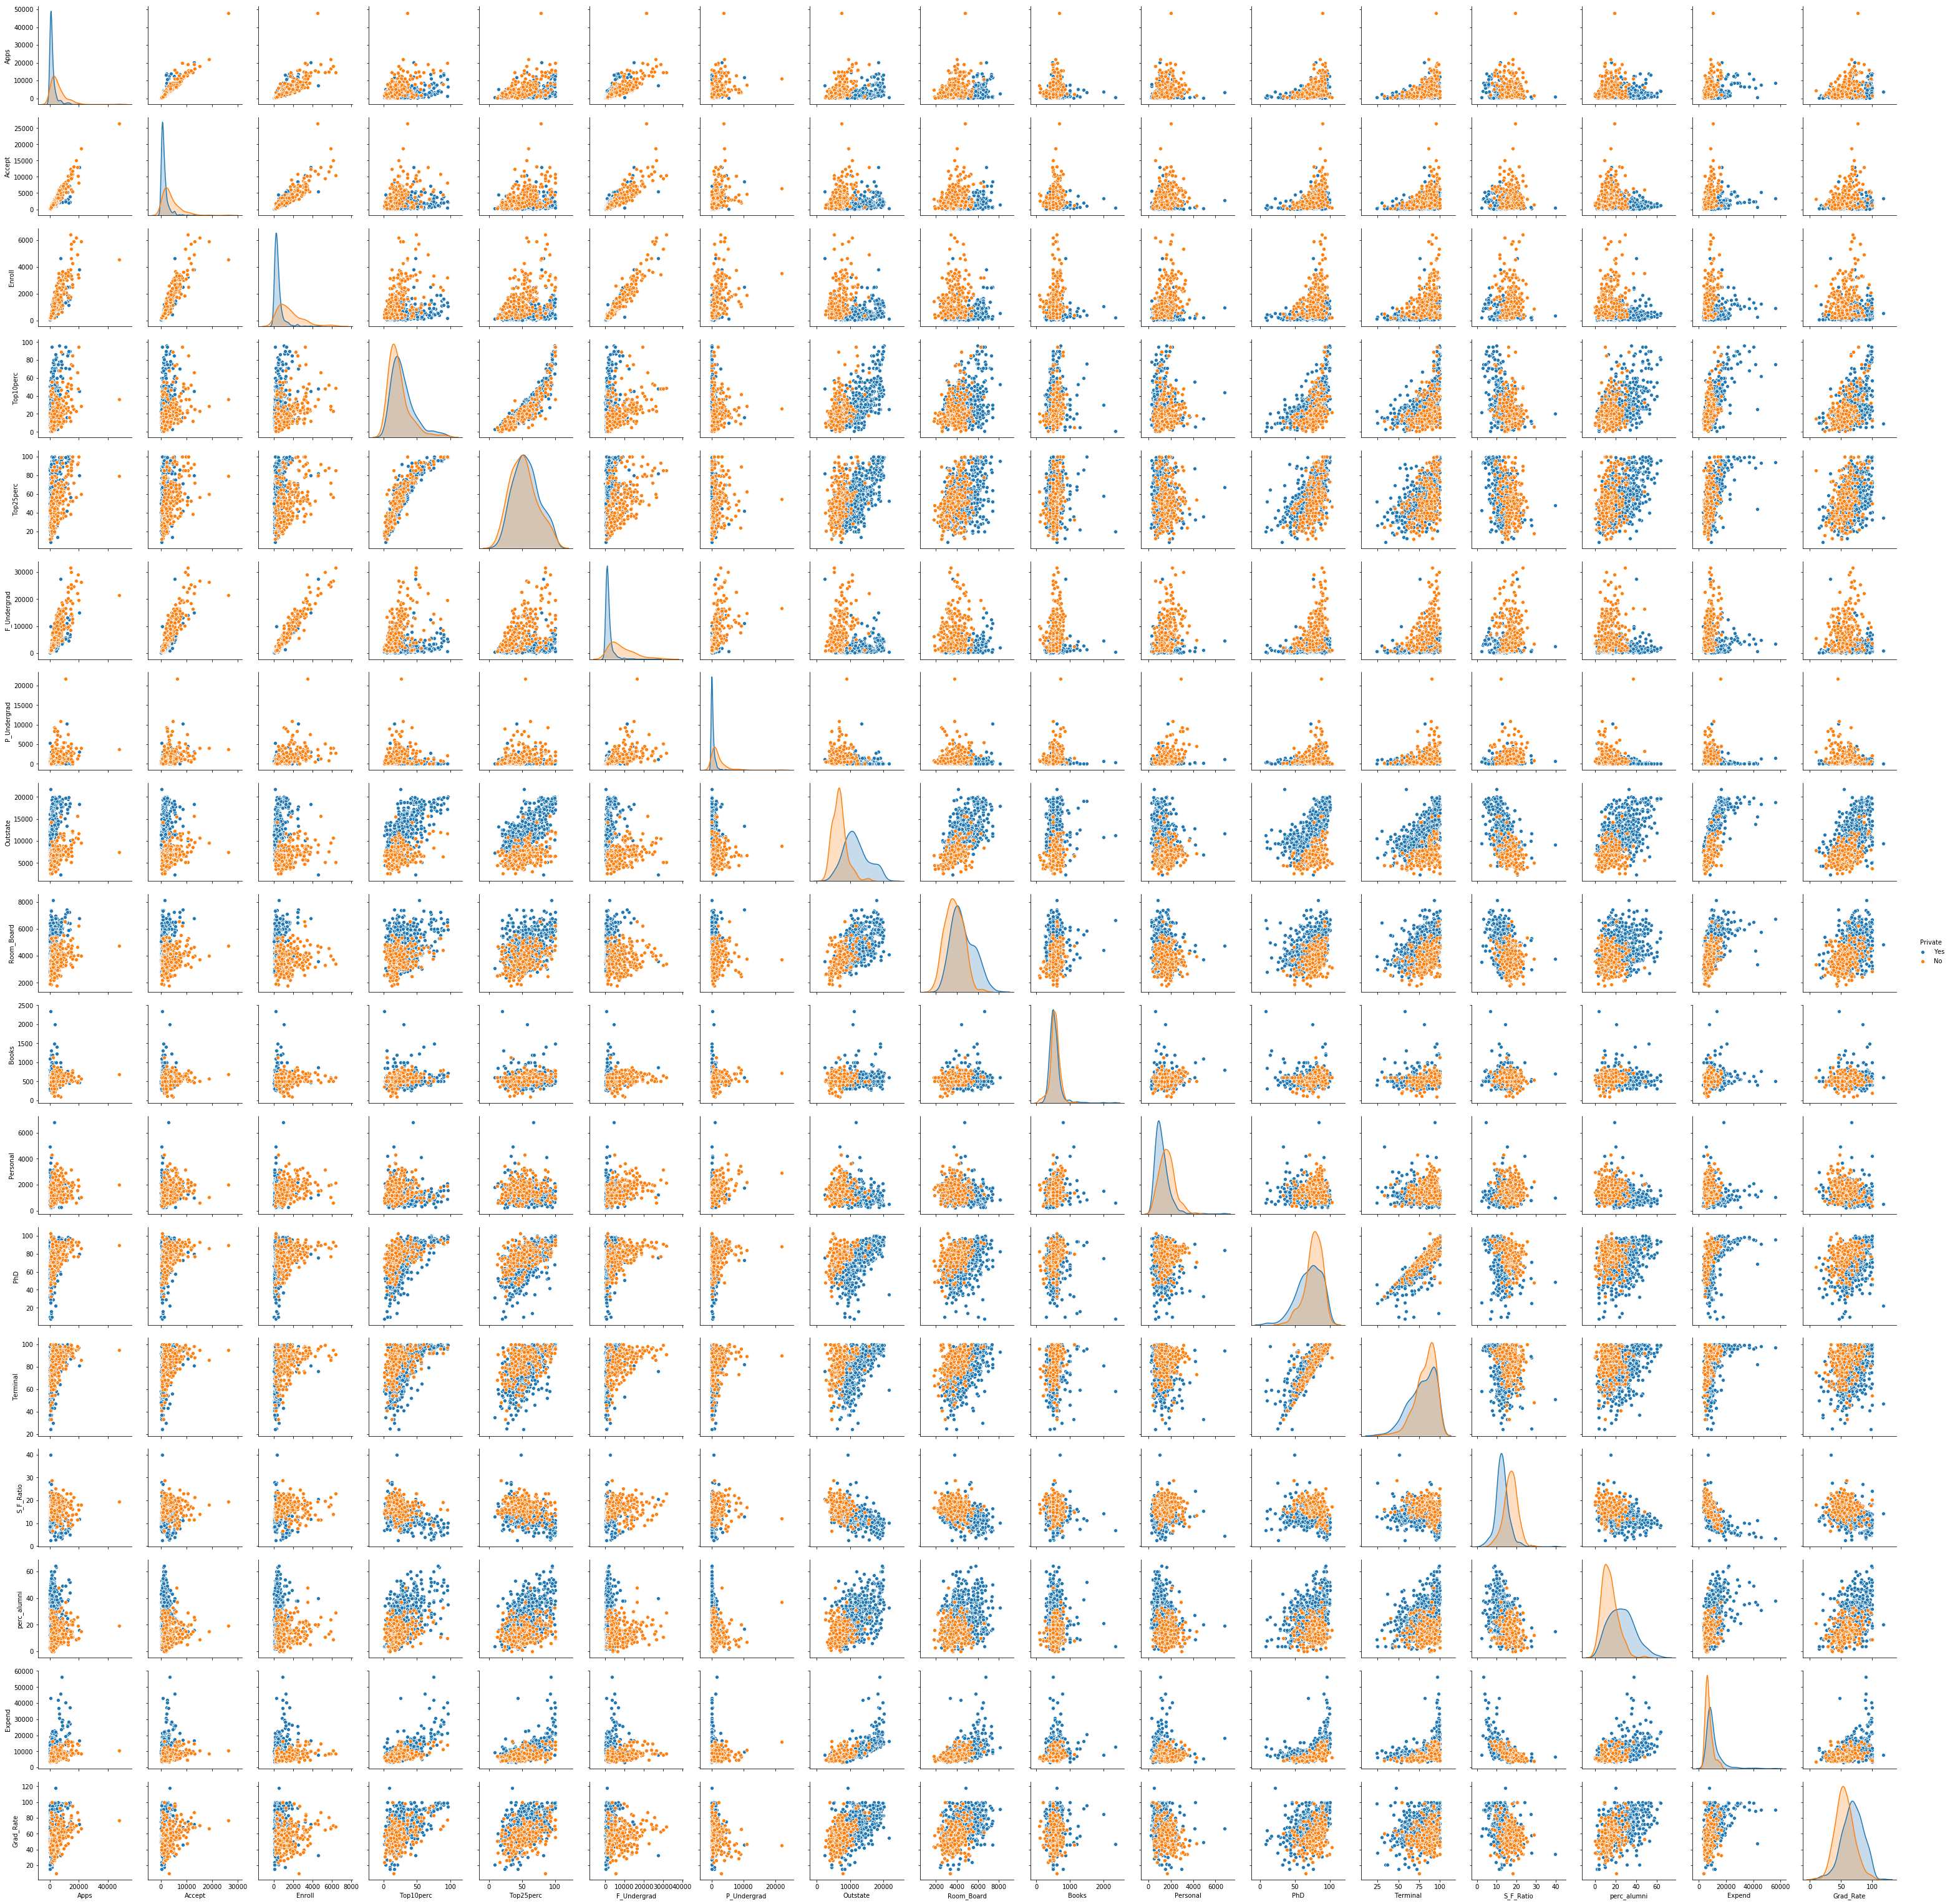

In [13]:
sns.pairplot(df.toPandas(), hue="Private")

In [14]:
# Check for missing Values
detect_missing(df)

,School,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
,,,,,,,,,,,,,,,,,,,
Count of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Check for Duplicates: 
detect_duplicates(df)

Count of rows:  777
Count of distinct rows:  777


In [17]:
df.columns

['School',
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumni',
 'Expend',
 'Grad_Rate']

In [10]:
#df = df.dropDuplicates() # Drop duplicate values

In [21]:
# Preparing Data for Machine Learning: ___________________________

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = [] 
stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]

# Label:    
label_stringIdx = StringIndexer(inputCol = 'Private', outputCol = 'label')

stages += [label_stringIdx]

# Continuous features: 
numericCols = ['Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F_Undergrad', 'P_Undergrad',  'Outstate',
                'Room_Board', 'Books', 'Personal', 'PhD', 'Terminal', 'S_F_Ratio', 'perc_alumni', 'Expend', 'Grad_Rate']

# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [22]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_piped = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- School: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: integer (nullable = true)
 |-- Accept: integer (nullable = true)
 |-- Enroll: integer (nullable = true)
 |-- Top10perc: integer (nullable = true)
 |-- Top25perc: integer (nullable = true)
 |-- F_Undergrad: integer (nullable = true)
 |-- P_Undergrad: integer (nullable = true)
 |-- Outstate: integer (nullable = true)
 |-- Room_Board: integer (nullable = true)
 |-- Books: integer (nullable = true)
 |-- Personal: integer (nullable = true)
 |-- PhD: integer (nullable = true)
 |-- Terminal: integer (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: integer (nullable = true)
 |-- Expend: integer (nullable = true)
 |-- Grad_Rate: integer (nullable = true)



In [23]:
train, test = df_piped.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 546
Test Dataset Count: 231


# 1) Logistic Regression Model: 

In [24]:
# To calculate the Calss Weight for Logestic Regression:
new_train=train.join(train.groupBy('label').count(), 'label', how='leftouter')
train_weight=new_train.withColumn('weight', train.count()/(new_train['count']))

train_weight.groupBy('weight').count().show()

+------------------+-----+
|            weight|count|
+------------------+-----+
|3.8450704225352115|  142|
|1.3514851485148516|  404|
+------------------+-----+



In [47]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, 
                                                            weightCol ='weight',
                                                            standardization=True)

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(lr.regParam, [0, 0.001, 0.1])
grid=grid.addGrid(lr.elasticNetParam, [0, 0.1, 1])
grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=lr,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [48]:
# fit the model:
models=cv.fit(train_weight)
best_lr=models.bestModel

# Best hyper-parameters: 
java_model = best_lr._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'elasticNetParam': 0.0, 'regParam': 0.001}


In [49]:
# Prediction on test dataset:
test_predictions = best_lr.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[6.54434267427174...|[0.99856383637544...|       0.0|
|  0.0|[4.87442365416705...|[0.99241842348111...|       0.0|
|  0.0|[7.88300816260073...|[0.99962304516867...|       0.0|
|  0.0|[6.64344573401130...|[0.99869916305494...|       0.0|
|  0.0|[5.16331143986481...|[0.99430984531134...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# print('Training roc_auc score: ', round(best_lr.summary.areaUnderROC, 2))
print('Training roc_auc score: ', round(best_lr.evaluate(train).areaUnderROC, 2))
print('Validation roc_auc score: ', round(best_lr.evaluate(test).areaUnderROC,2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_lr.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_lr.transform(test)),2))

Training roc_auc score:  0.98
Validation roc_auc score:  0.97 

Training f1 score:  0.94
Validation f1 score:  0.93


Confusion matrix, without normalization
[[149  12]
 [  4  66]]
Normalized confusion matrix
[[0.93 0.07]
 [0.06 0.94]]


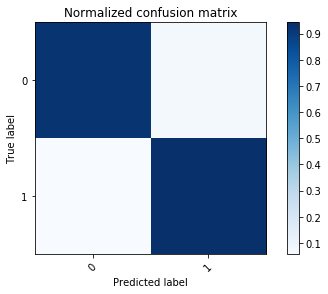

In [51]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

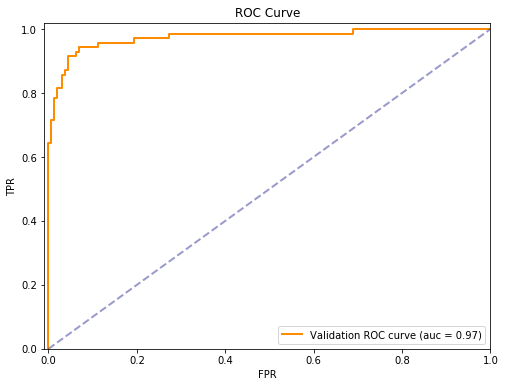

In [52]:
# ROC curve:______________________________________
validation_accuracy=best_lr.evaluate(test)
roc=validation_accuracy.roc.toPandas()
roc_auc=validation_accuracy.areaUnderROC

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(roc['FPR'],roc['TPR'], color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([-0.01, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

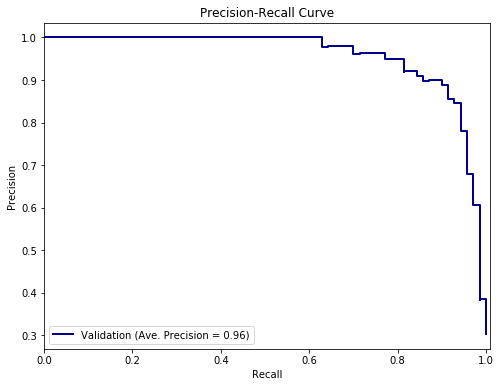

In [53]:
# Precision-Recall curve: ____________________________________________
validation_accuracy=best_lr.evaluate(test)
pr_test=validation_accuracy.pr.toPandas()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_eval=BinaryClassificationEvaluator(metricName='areaUnderPR')
apr_test=my_eval.evaluate(best_lr.transform(test))

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(pr_test['recall'],pr_test['precision'], color='darkblue', lw=2, label='Validation (Ave. Precision = %0.2f)' % apr_test)

plt.xlim([0, 1.01])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.show()

# 2) Random Forest Model: 

In [55]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(rf.maxDepth, [3, 5, 10])
grid=grid.addGrid(rf.numTrees, [70])
grid=grid.addGrid(rf.maxBins, [4, 8, 16, 32])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=rf,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [56]:
# fit the model:
models=cv.fit(train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxDepth': 10, 'numTrees': 70, 'maxBins': 32}


In [57]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+-------------+--------------------+----------+
|label|rawPrediction|         probability|prediction|
+-----+-------------+--------------------+----------+
|  0.0|   [69.0,1.0]|[0.98571428571428...|       0.0|
|  0.0|   [68.0,2.0]|[0.97142857142857...|       0.0|
|  0.0|   [70.0,0.0]|           [1.0,0.0]|       0.0|
|  0.0|   [70.0,0.0]|           [1.0,0.0]|       0.0|
|  0.0|   [70.0,0.0]|           [1.0,0.0]|       0.0|
+-----+-------------+--------------------+----------+
only showing top 5 rows



In [58]:
my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Training roc_auc score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Training roc_auc score:  1.0
Validation roc_auc score:  0.97 

Training f1 score:  1.0
Validation f1 score:  0.94


Confusion matrix, without normalization
[[156   5]
 [  8  62]]
Normalized confusion matrix
[[0.97 0.03]
 [0.11 0.89]]


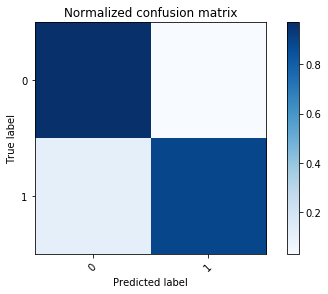

In [59]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

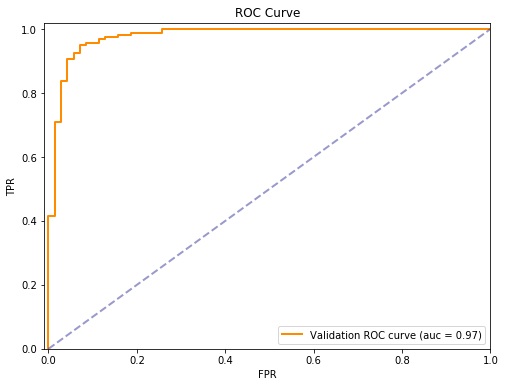

In [60]:
# ROC curve:______________________________________
prediction = best_rf.transform(test)
results= prediction.select(['probability', 'label']).collect()
results = [(i[0][0], 1.0-i[1]) for i in results]

from sklearn.metrics import roc_curve, auc
 
fpr= dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results]
y_score = [i[0] for i in results]
 
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(fpr, tpr, color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([-.01, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")


plt.show()

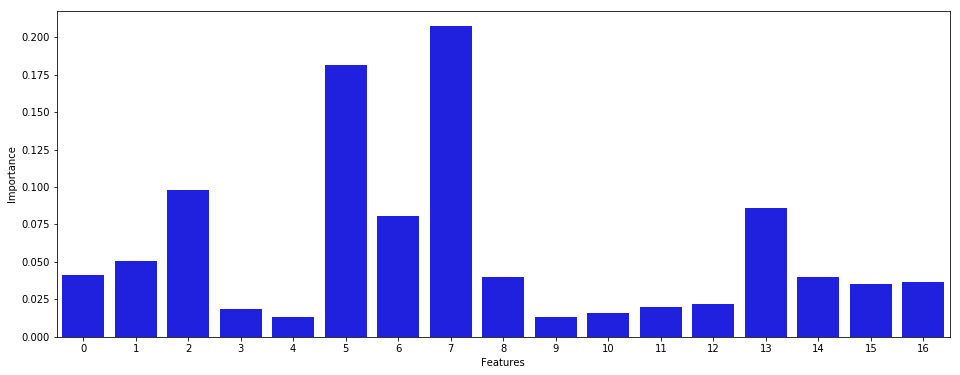

In [61]:
# Feature Importance: 
im=best_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()

# 3) Gradient-Boosted Trees:

In [62]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.MulticlassClassificationEvaluator(metricName='f1')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(gb.maxDepth, [2, 4, 6])
grid=grid.addGrid(gb.maxIter, [40])
grid=grid.addGrid(gb.maxBins, [8, 16, 24, 32])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=gb,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [63]:
# fit the model:
models=cv.fit(train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxIter': 40, 'maxDepth': 2, 'maxBins': 24}


In [64]:
print("Training f1 score:  ", round(evaluator.evaluate(best_gb.transform(train)),2))
print("Validation f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Training f1 score:   0.96
Validation f1 score:   0.93


In [65]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[156   5]
 [ 12  58]]
Normalized confusion matrix
[[0.97 0.03]
 [0.17 0.83]]


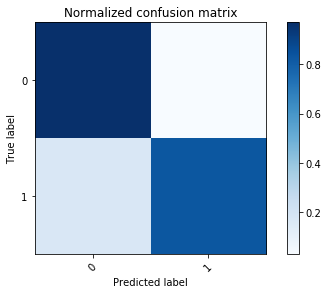

In [66]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

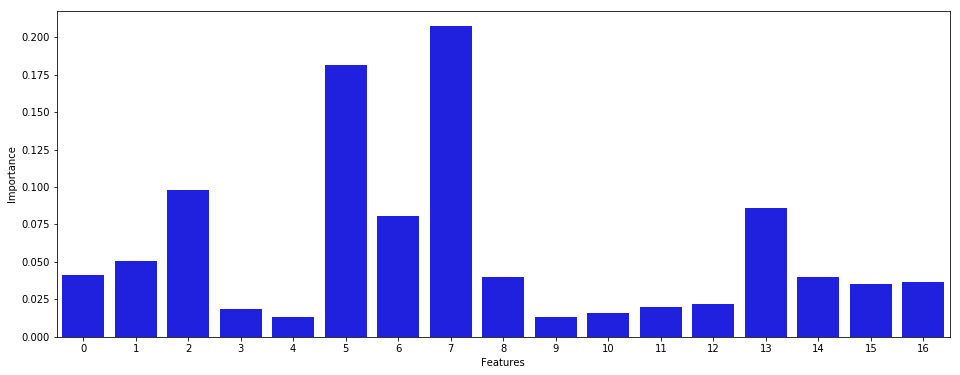

In [67]:
# Feature Importance: 
im=best_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()